In [30]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import os

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

## Load dataset

In [32]:
dataset_path = '../../dataset/additional_datasets/'
dataset_name = 'Breast_GSE45827'
dataset_norm_suffix = '_norm'
dataset_pca_suffix = '_pca'

with open('../../preprocessing/class_mapping.pickle', 'rb') as handle:
    class_mapping = pickle.load(handle)

In [33]:
df_norm = pd.read_csv(dataset_path + dataset_name + dataset_norm_suffix + '.csv', index_col=0)
X = df_norm.drop('type', axis=1)
y = df_norm.type

### PCA

In [34]:
PCA_COMPONENTS = 2

def transform_to_PCA(X, y, pca_components=PCA_COMPONENTS):
    pca = PCA(n_components=pca_components)
    pca.fit(X)
    X_pca = pca.transform(X)
    y_pca = y.copy()

    return X_pca, y_pca

In [35]:
X_pca, y_pca = transform_to_PCA(X, y)
X_pca_90, y_pca_90 = transform_to_PCA(X, y, pca_components=90)

In [36]:
X_pca_90.shape

(151, 90)

### t-SNE

In [37]:
def tsne(X, y):
    tsne = TSNE(n_components=2, random_state=0)
    X_tsne = tsne.fit_transform(X)
    y_tsne = y.copy()

    return X_tsne, y_tsne

In [38]:
X_tsne, y_tsne = tsne(X, y)

c:\Users\Branko\miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Branko\miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


## Gaussian Mixture

In [39]:
covariance_types = ['full', 'tied', 'diag', 'spherical']

In [40]:
def gaussian_mixture(X, n_components, covariance_type, ax=None):
    gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=0)
    gmm.fit(X)
    y_pred = gmm.predict(X)

    if ax:
        ax.scatter(X[:, 0], X[:, 1], c=y_pred)
        ax.set_title(f"n_components={n_components}")
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")

    bic = gmm.bic(X)
    silhouette = silhouette_score(X, y_pred)

    return bic, silhouette

### PCA

In [41]:
# store bic for each covariance type and n_components in matrix
n_components_min = 2
n_components_max = 10

bic_matrix = np.zeros((len(covariance_types), n_components_max - n_components_min))
silhouette_matrix = np.zeros((len(covariance_types), n_components_max - n_components_min))

for covariance_type in covariance_types:
    covariance_type_ind = covariance_types.index(covariance_type)
    print('covariance type: {}'.format(covariance_type))

    for n_components in range(n_components_min, n_components_max):
        n_components_idx = n_components - n_components_min
        bic, silhouette = gaussian_mixture(X_pca, n_components, covariance_type, ax=None)

        bic_matrix[covariance_type_ind][n_components_idx] = bic
        silhouette_matrix[covariance_type_ind][n_components_idx] = silhouette
        # print('PCA, : n_components: {}, BIC: {}, silhouette: {}'.format(n_components, bic, silhouette))

    print()

covariance type: full

covariance type: tied

covariance type: diag

covariance type: spherical



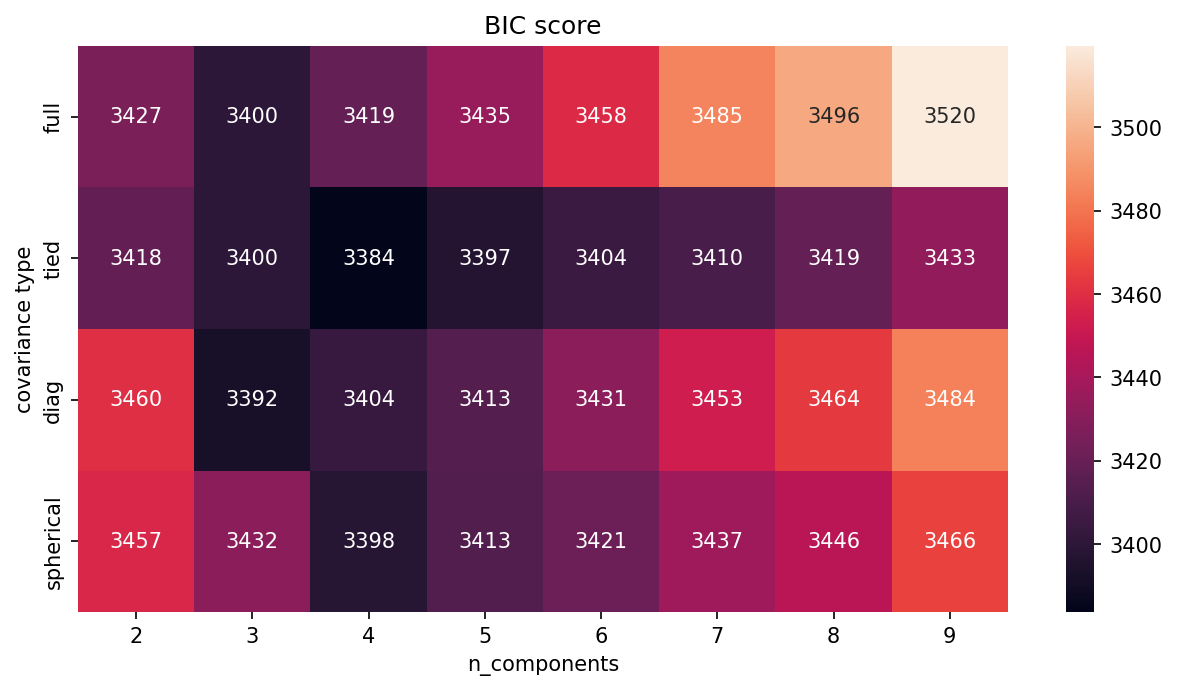

In [42]:
# plot bic matrix

fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
sns.heatmap(bic_matrix, ax=ax, annot=True, fmt='.0f', xticklabels=range(n_components_min, n_components_max), yticklabels=covariance_types)
ax.set_title('BIC score')
ax.set_xlabel('n_components')
ax.set_ylabel('covariance type')

# Save figure
if not os.path.exists('../../figures/gaussian_mixture'):
    os.mkdir('../../figures/gaussian_mixture') 

plt.savefig(f'../../figures/gaussian_mixture/Gaussian Mixture - PCA bic_per_cov_type.png')

plt.show()

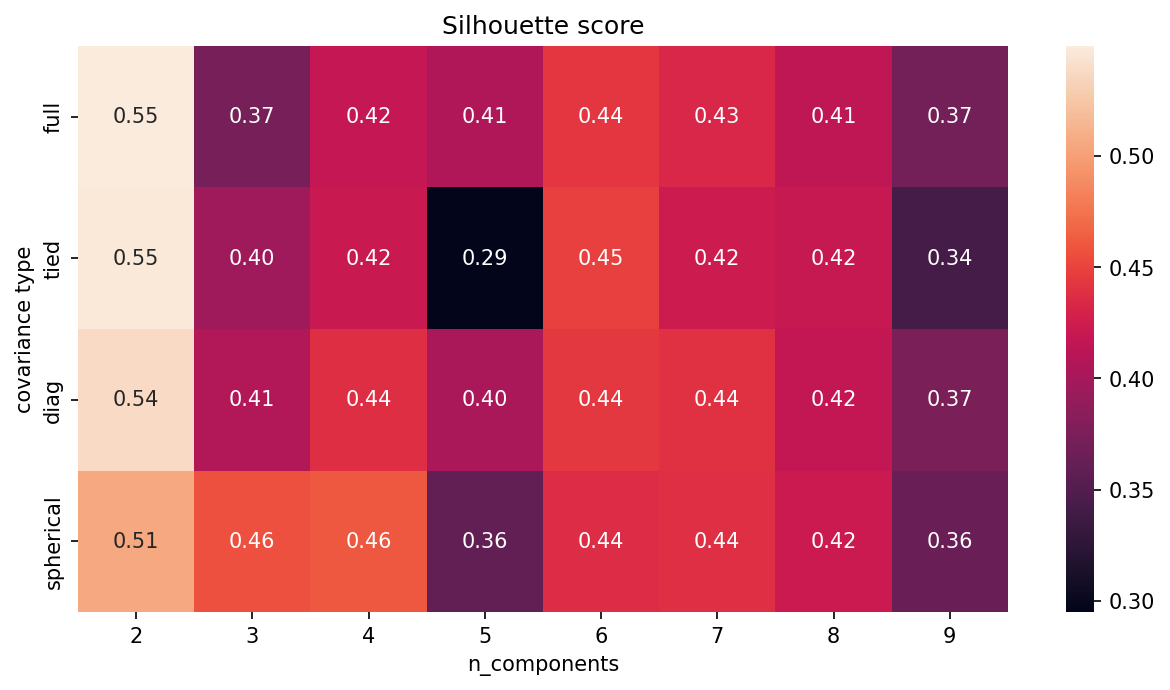

In [43]:
# plot silhouette matrix

fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
sns.heatmap(silhouette_matrix, ax=ax, annot=True, fmt='.2f', xticklabels=range(n_components_min, n_components_max), yticklabels=covariance_types)
ax.set_title('Silhouette score')
ax.set_xlabel('n_components')
ax.set_ylabel('covariance type')

# Save figure
if not os.path.exists('../../figures/gaussian_mixture'):
    os.mkdir('../../figures/gaussian_mixture') 

plt.savefig(f'../../figures/gaussian_mixture/Gaussian Mixture - PCA silhouette_per_cov_type.png')

plt.show()

#### Spherical

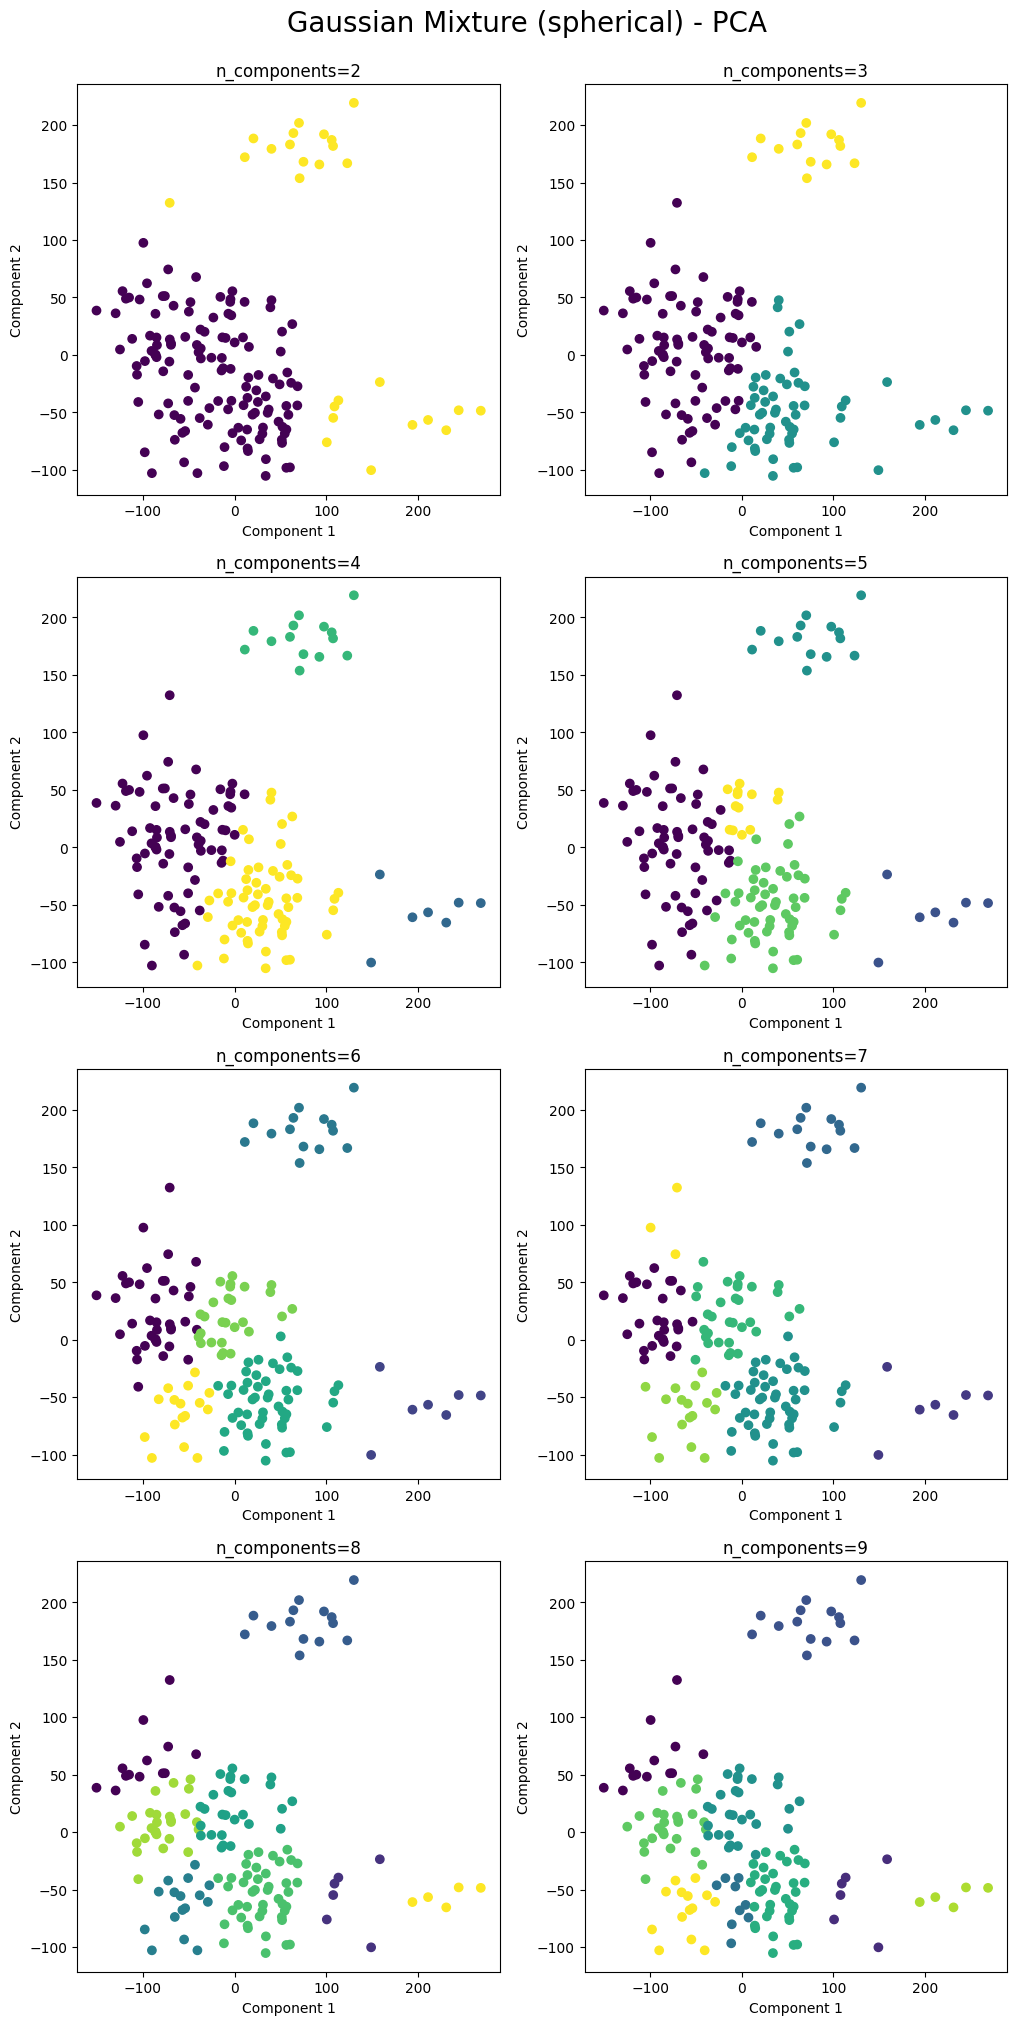

In [44]:
fig, axs = plt.subplots(4, 2, figsize=(12, 25), dpi=100)
plt.suptitle('Gaussian Mixture (spherical) - PCA', fontsize=20, y=0.91)

spherical_info = []

for n_components in range(2, 10):
    bic, silhouette = gaussian_mixture(X_pca, n_components=n_components, covariance_type='spherical', ax=axs[(n_components - 2)//2][n_components % 2])


    spherical_info.append({
        'n_components': n_components,
        'bic': bic,
        'silhouette': silhouette
    })

# Save figure
if not os.path.exists('../../figures/gaussian_mixture'):
    os.mkdir('../../figures/gaussian_mixture') 

plt.savefig(f'../../figures/gaussian_mixture/Gaussian Mixture - PCA spherical.png')

plt.show()

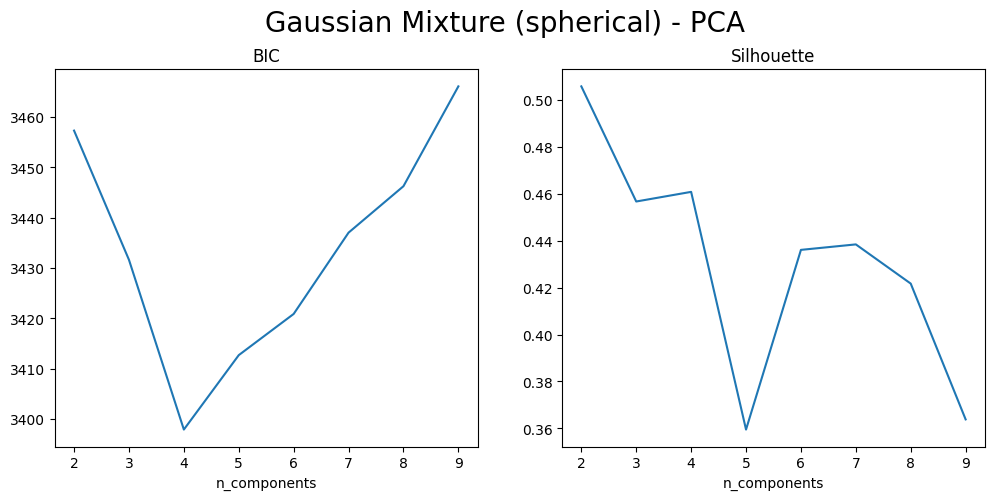

In [45]:
# plot bic and silhouette for spherical covariance type

fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=100)
plt.suptitle('Gaussian Mixture (spherical) - PCA', fontsize=20, y=1)

axs[0].plot([info['n_components'] for info in spherical_info], [info['bic'] for info in spherical_info])
axs[0].set_title('BIC')
axs[0].set_xlabel('n_components')

axs[1].plot([info['n_components'] for info in spherical_info], [info['silhouette'] for info in spherical_info])
axs[1].set_title('Silhouette')
axs[1].set_xlabel('n_components')

# Save figure
if not os.path.exists('../../figures/gaussian_mixture'):
    os.mkdir('../../figures/gaussian_mixture') 

plt.savefig(f'../../figures/gaussian_mixture/Gaussian Mixture - PCA spherical bic_and_silhouette.png')

plt.show()

#### Full

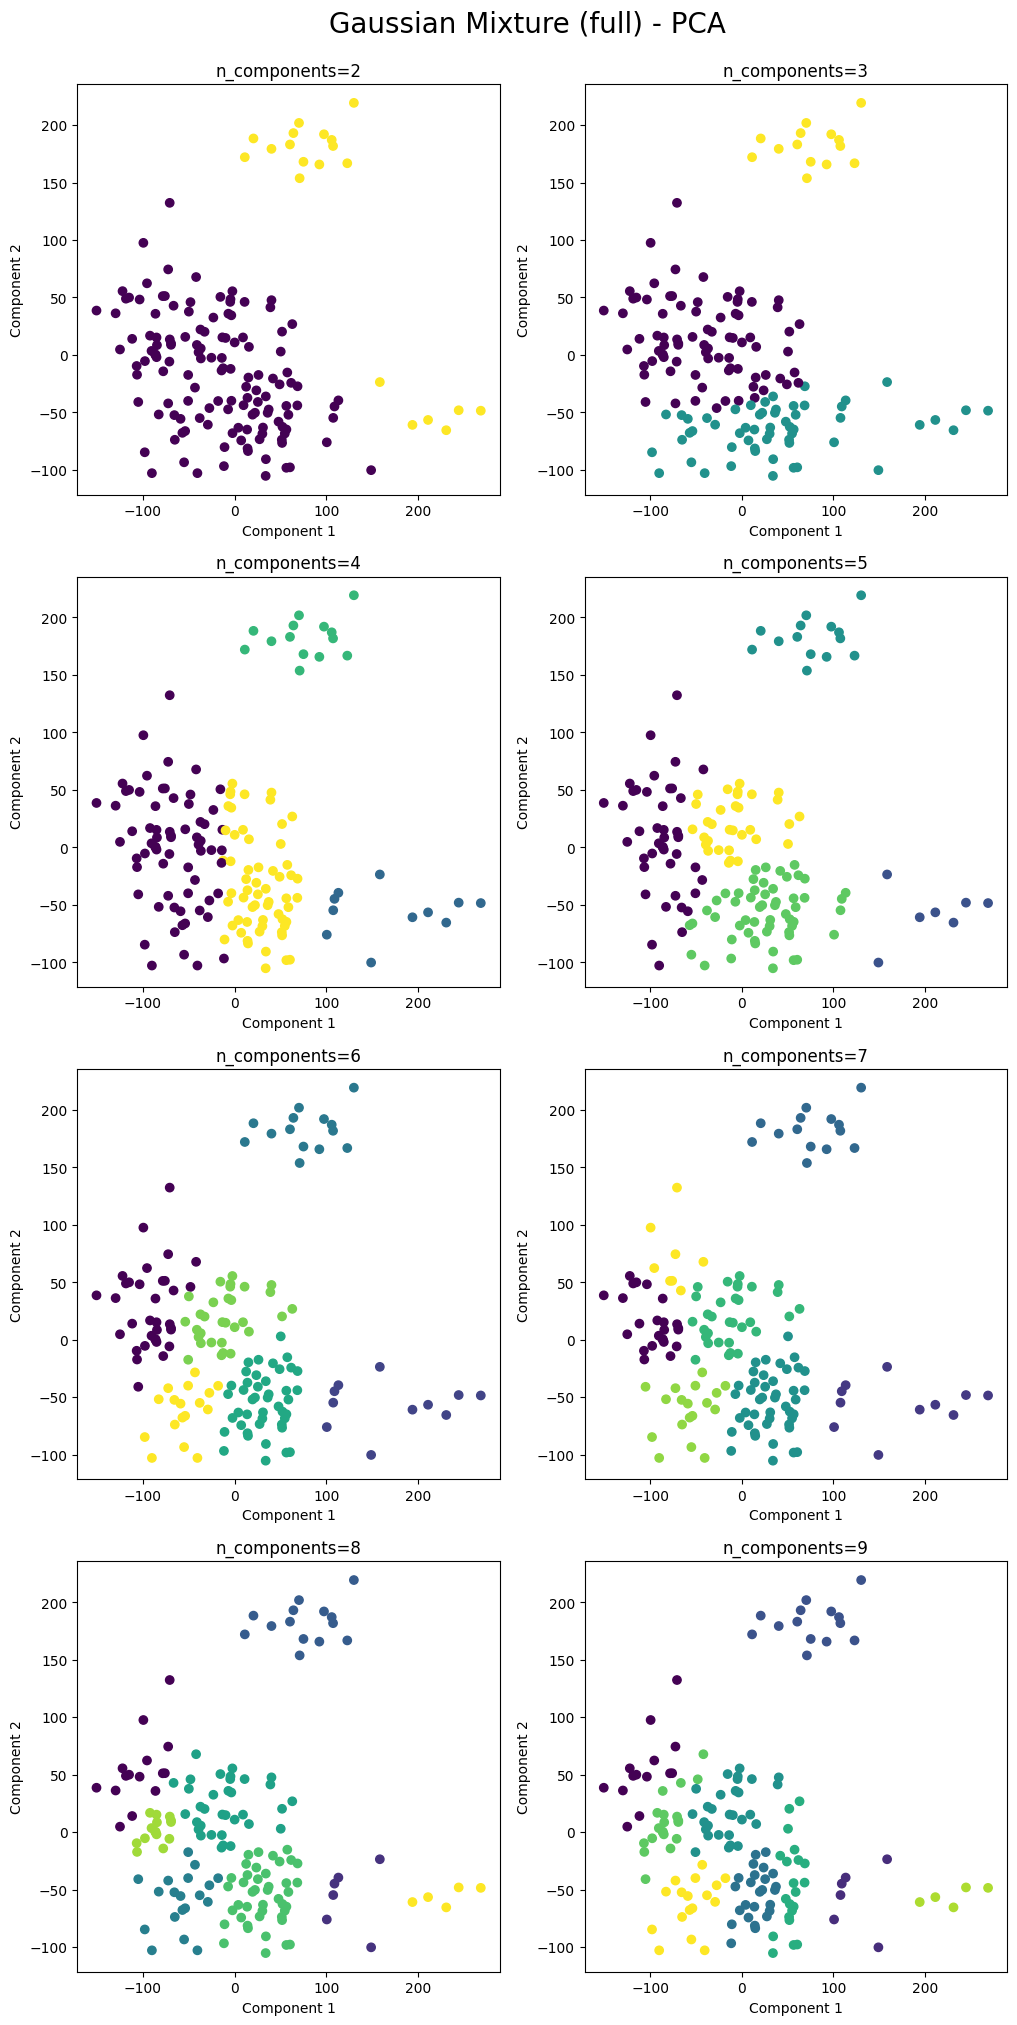

In [46]:
fig, axs = plt.subplots(4, 2, figsize=(12, 25), dpi=100)
plt.suptitle('Gaussian Mixture (full) - PCA', fontsize=20, y=0.91)

full_info = []

for n_components in range(2, 10):
    bic, silhouette = gaussian_mixture(X_pca, n_components=n_components, covariance_type='full', ax=axs[(n_components - 2)//2][n_components % 2])


    full_info.append({
        'n_components': n_components,
        'bic': bic,
        'silhouette': silhouette
    })

# Save figure
if not os.path.exists('../../figures/gaussian_mixture'):
    os.mkdir('../../figures/gaussian_mixture') 

plt.savefig(f'../../figures/gaussian_mixture/Gaussian Mixture - PCA full.png')

plt.show()

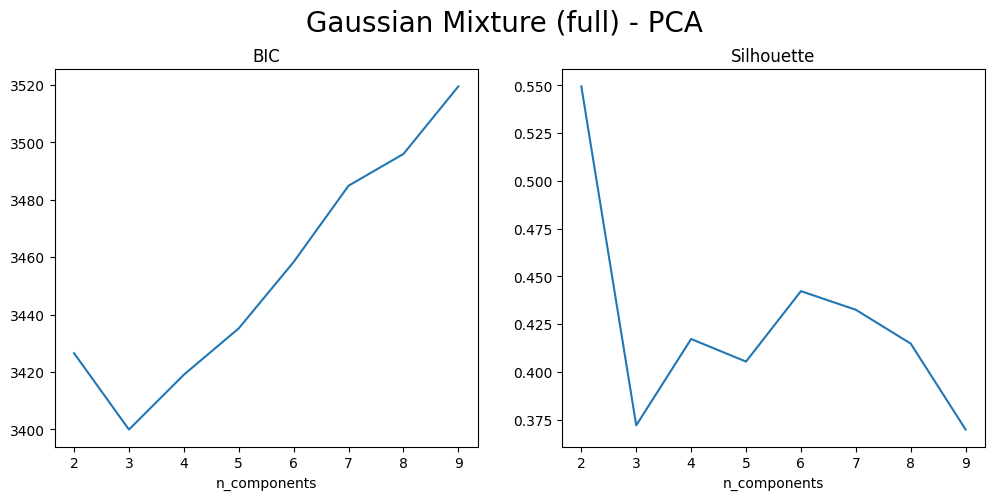

In [47]:
# plot bic and silhouette for full covariance type

fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=100)
plt.suptitle('Gaussian Mixture (full) - PCA', fontsize=20, y=1)

axs[0].plot([info['n_components'] for info in full_info], [info['bic'] for info in full_info])
axs[0].set_title('BIC')
axs[0].set_xlabel('n_components')

axs[1].plot([info['n_components'] for info in full_info], [info['silhouette'] for info in full_info])
axs[1].set_title('Silhouette')
axs[1].set_xlabel('n_components')

# Save figure
if not os.path.exists('../../figures/gaussian_mixture'):
    os.mkdir('../../figures/gaussian_mixture') 

plt.savefig(f'../../figures/gaussian_mixture/Gaussian Mixture - PCA full bic_and_silhouette.png')

plt.show()

#### Tied

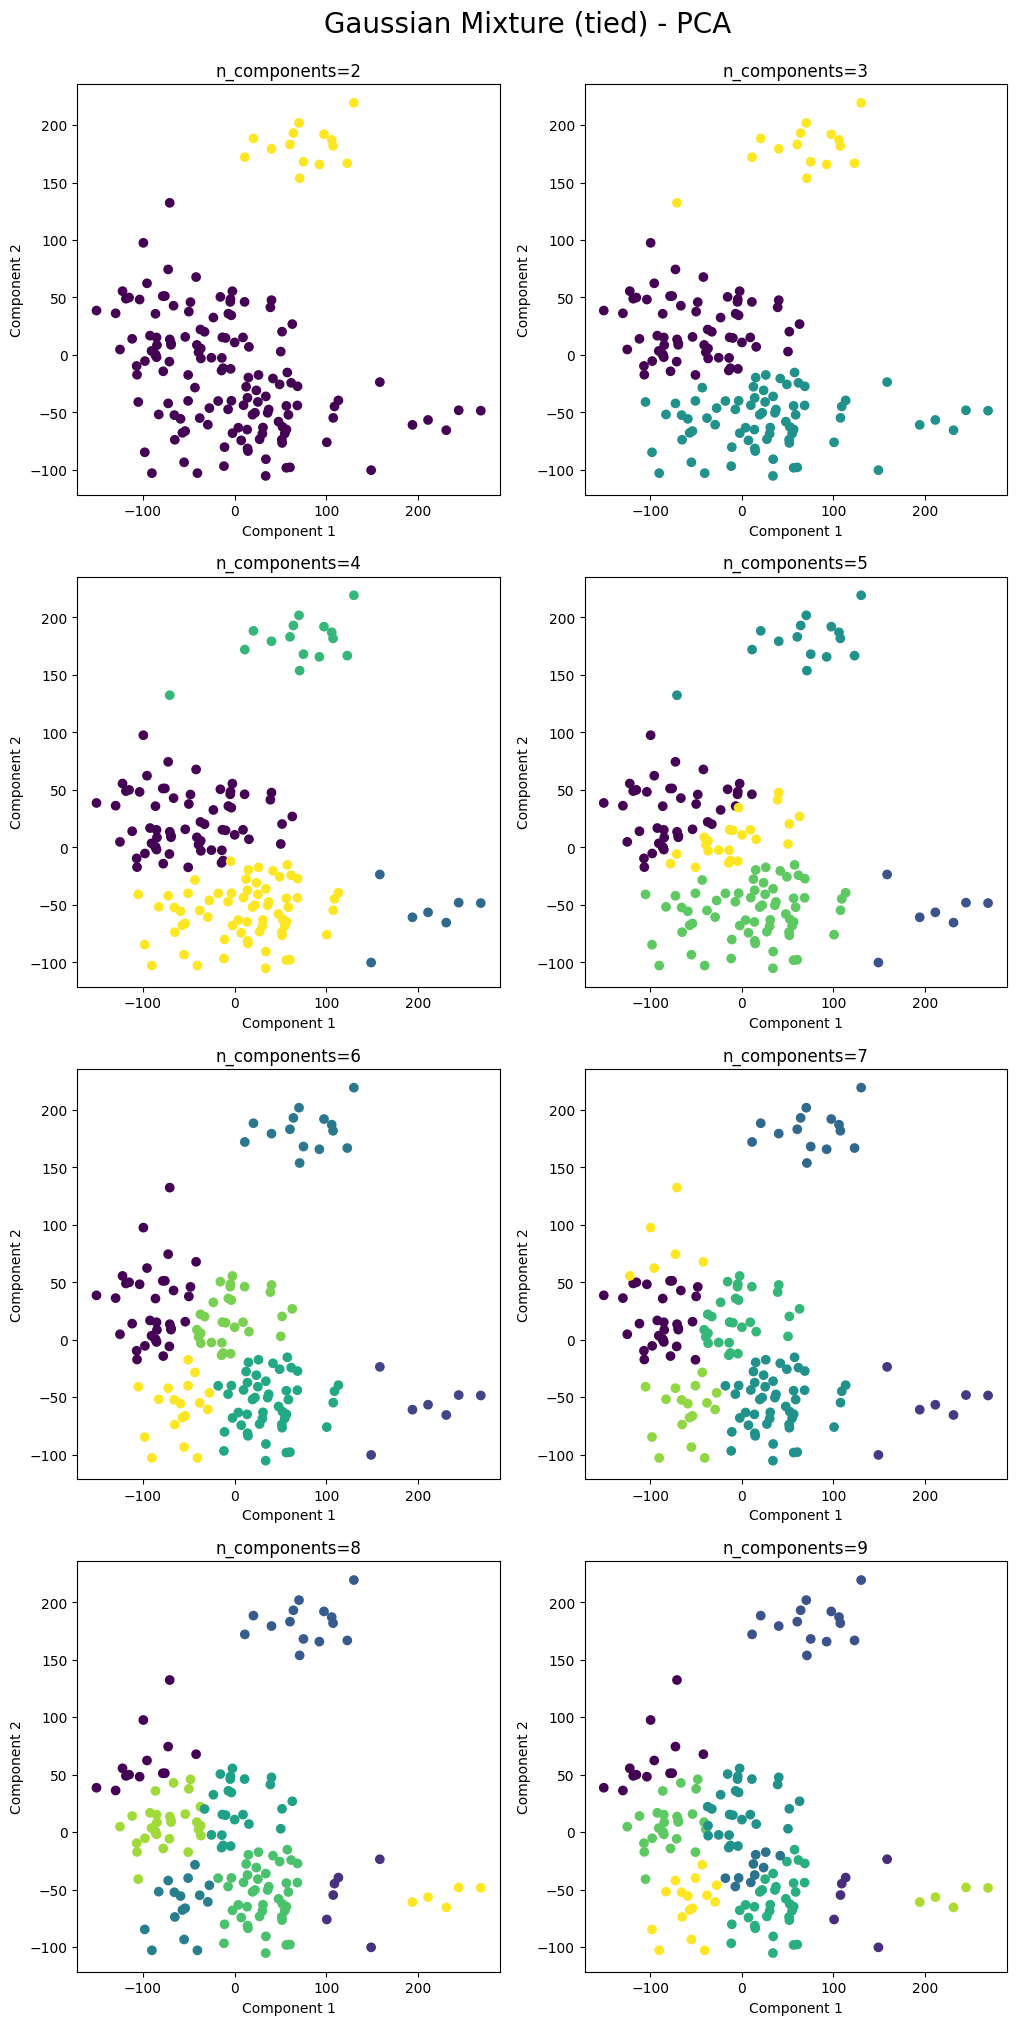

In [48]:
fig, axs = plt.subplots(4, 2, figsize=(12, 25), dpi=100)
plt.suptitle('Gaussian Mixture (tied) - PCA', fontsize=20, y=0.91)

tied_info = []

for n_components in range(2, 10):
    bic, silhouette = gaussian_mixture(X_pca, n_components=n_components, covariance_type='tied', ax=axs[(n_components - 2)//2][n_components % 2])


    tied_info.append({
        'n_components': n_components,
        'bic': bic,
        'silhouette': silhouette
    })

# Save figure
if not os.path.exists('../../figures/gaussian_mixture'):
    os.mkdir('../../figures/gaussian_mixture') 

plt.savefig(f'../../figures/gaussian_mixture/Gaussian Mixture - PCA tied.png')

plt.show()

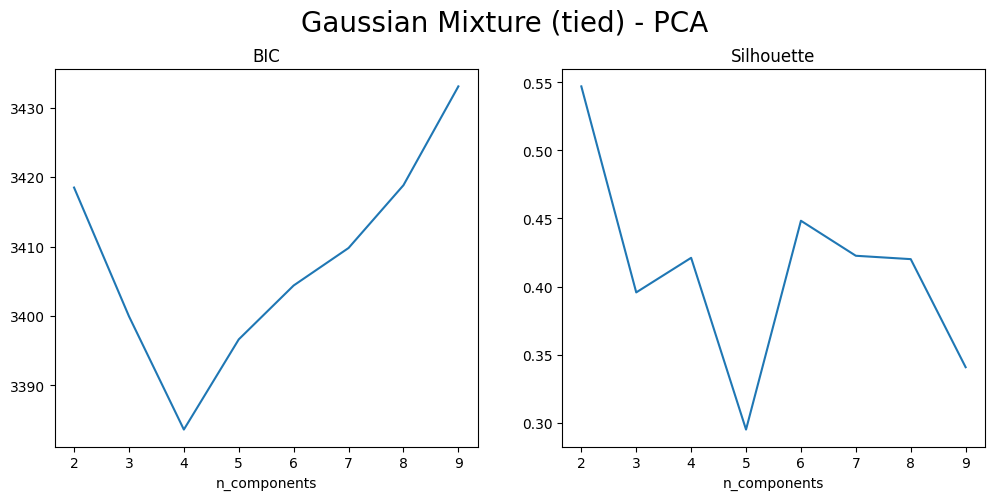

In [49]:
# plot bic and silhouette for tied covariance type

fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=100)
plt.suptitle('Gaussian Mixture (tied) - PCA', fontsize=20, y=1)

axs[0].plot([info['n_components'] for info in tied_info], [info['bic'] for info in tied_info])
axs[0].set_title('BIC')
axs[0].set_xlabel('n_components')

axs[1].plot([info['n_components'] for info in tied_info], [info['silhouette'] for info in tied_info])
axs[1].set_title('Silhouette')
axs[1].set_xlabel('n_components')

# Save figure
if not os.path.exists('../../figures/gaussian_mixture'):
    os.mkdir('../../figures/gaussian_mixture') 

plt.savefig(f'../../figures/gaussian_mixture/Gaussian Mixture - PCA tied bic_and_silhouette.png')

plt.show()

### t-SNE

In [50]:
# store bic for each covariance type and n_components in matrix
n_components_min = 2
n_components_max = 10

bic_matrix = np.zeros((len(covariance_types), n_components_max - n_components_min))
silhouette_matrix = np.zeros((len(covariance_types), n_components_max - n_components_min))

for covariance_type in covariance_types:
    covariance_type_ind = covariance_types.index(covariance_type)
    print('covariance type: {}'.format(covariance_type))

    for n_components in range(n_components_min, n_components_max):
        n_components_idx = n_components - n_components_min
        bic, silhouette = gaussian_mixture(X_tsne, n_components, covariance_type, ax=None)

        bic_matrix[covariance_type_ind][n_components_idx] = bic
        silhouette_matrix[covariance_type_ind][n_components_idx] = silhouette
        # print('PCA, : n_components: {}, BIC: {}, silhouette: {}'.format(n_components, bic, silhouette))

    print()

covariance type: full

covariance type: tied

covariance type: diag

covariance type: spherical



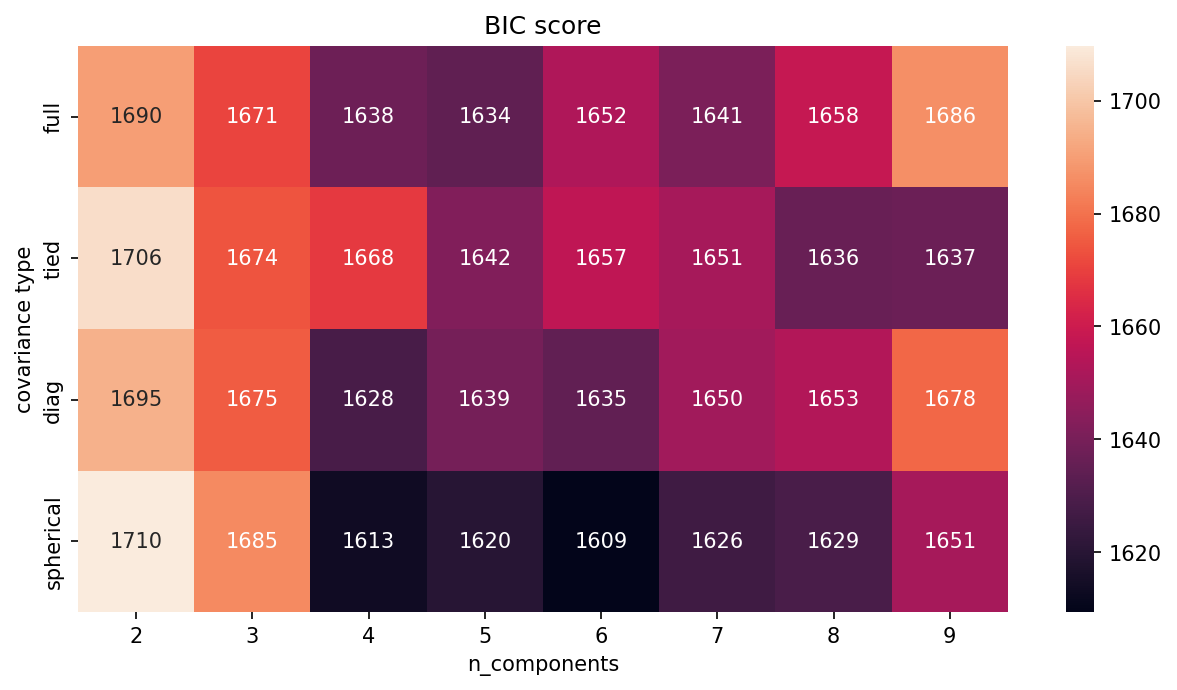

In [51]:
# plot bic matrix

fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
sns.heatmap(bic_matrix, ax=ax, annot=True, fmt='.0f', xticklabels=range(n_components_min, n_components_max), yticklabels=covariance_types)
ax.set_title('BIC score')
ax.set_xlabel('n_components')
ax.set_ylabel('covariance type')

# Save figure
if not os.path.exists('../../figures/gaussian_mixture'):
    os.mkdir('../../figures/gaussian_mixture') 

plt.savefig(f'../../figures/gaussian_mixture/Gaussian Mixture - tSNE bic_per_cov_type.png')

plt.show()

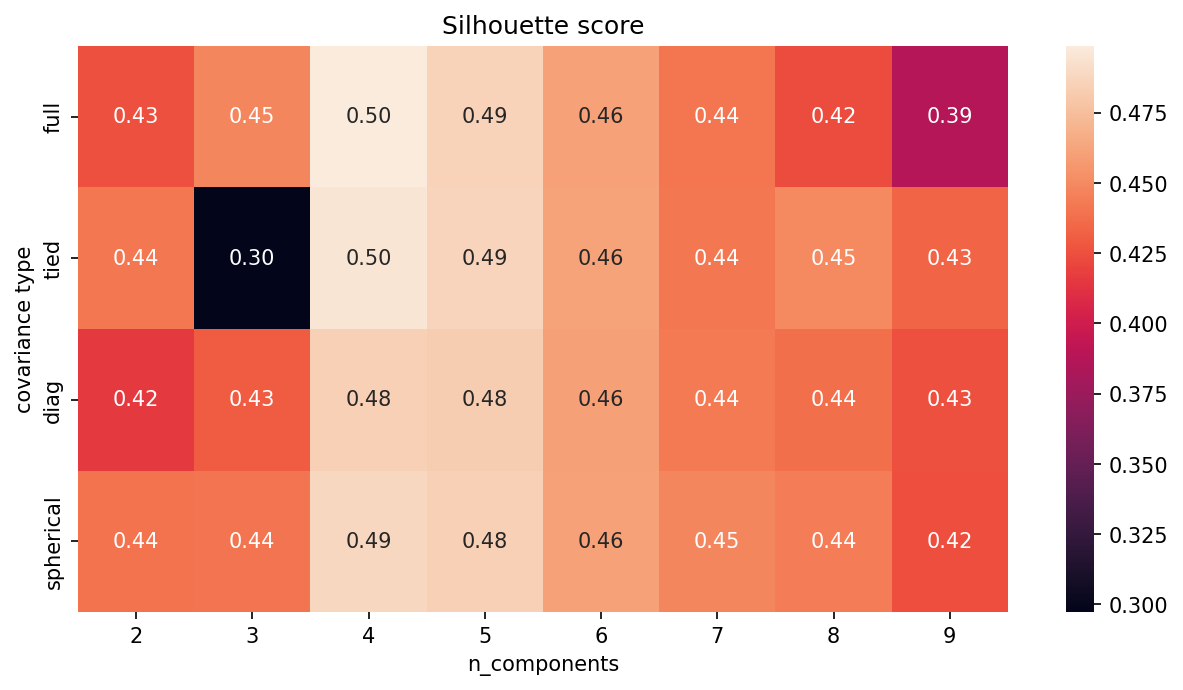

In [52]:
# plot silhouette matrix

fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
sns.heatmap(silhouette_matrix, ax=ax, annot=True, fmt='.2f', xticklabels=range(n_components_min, n_components_max), yticklabels=covariance_types)
ax.set_title('Silhouette score')
ax.set_xlabel('n_components')
ax.set_ylabel('covariance type')

# Save figure
if not os.path.exists('../../figures/gaussian_mixture'):
    os.mkdir('../../figures/gaussian_mixture') 

plt.savefig(f'../../figures/gaussian_mixture/Gaussian Mixture - tSNE silhouette_per_cov_type.png')

plt.show()

#### Full

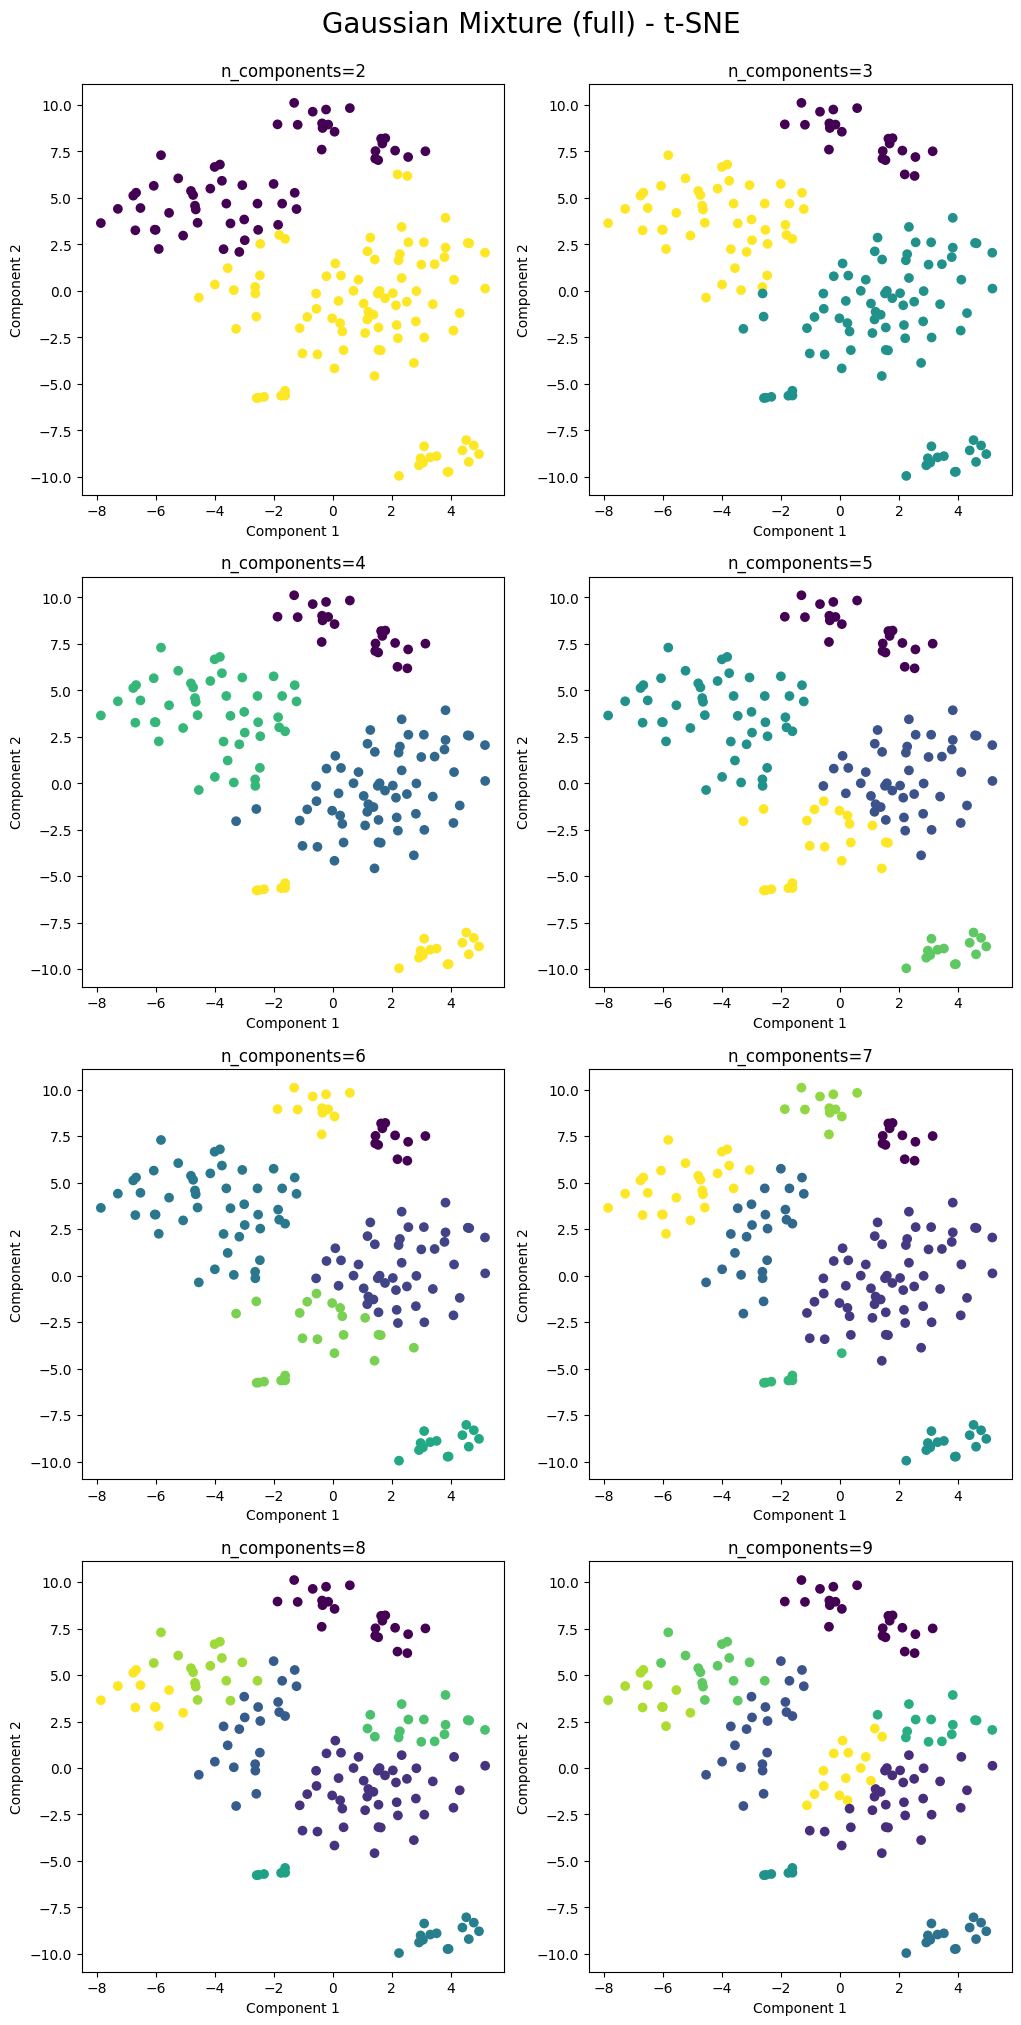

In [53]:
fig, axs = plt.subplots(4, 2, figsize=(12, 25), dpi=100)
plt.suptitle('Gaussian Mixture (full) - t-SNE', fontsize=20, y=0.91)

full_info = []

for n_components in range(2, 10):
    bic, silhouette = gaussian_mixture(X_tsne, n_components=n_components, covariance_type='full', ax=axs[(n_components - 2)//2][n_components % 2])

    full_info.append({
        'n_components': n_components,
        'bic': bic,
        'silhouette': silhouette
    })

# Save figure
if not os.path.exists('../../figures/gaussian_mixture'):
    os.mkdir('../../figures/gaussian_mixture') 

plt.savefig(f'../../figures/gaussian_mixture/Gaussian Mixture - tSNE full.png')

plt.show()

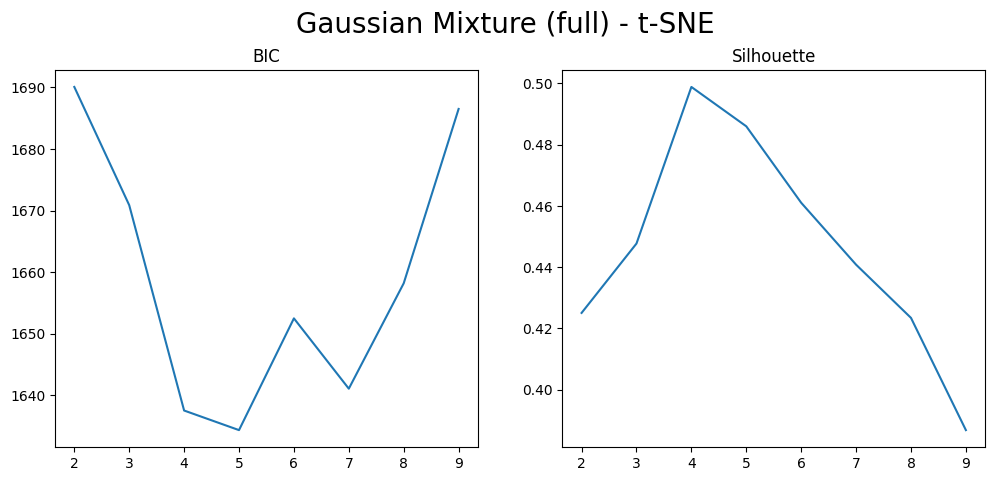

In [54]:
# plot bic and silhouette for full covariance type

fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=100)
plt.suptitle('Gaussian Mixture (full) - t-SNE', fontsize=20, y=1)

axs[0].plot([info['n_components'] for info in full_info], [info['bic'] for info in full_info])
axs[0].set_title('BIC')

axs[1].plot([info['n_components'] for info in full_info], [info['silhouette'] for info in full_info])
axs[1].set_title('Silhouette')

# Save figure
if not os.path.exists('../../figures/gaussian_mixture'):
    os.mkdir('../../figures/gaussian_mixture') 

plt.savefig(f'../../figures/gaussian_mixture/Gaussian Mixture - tSNE full bic_and_silhouette.png')

plt.show()

#### Tied

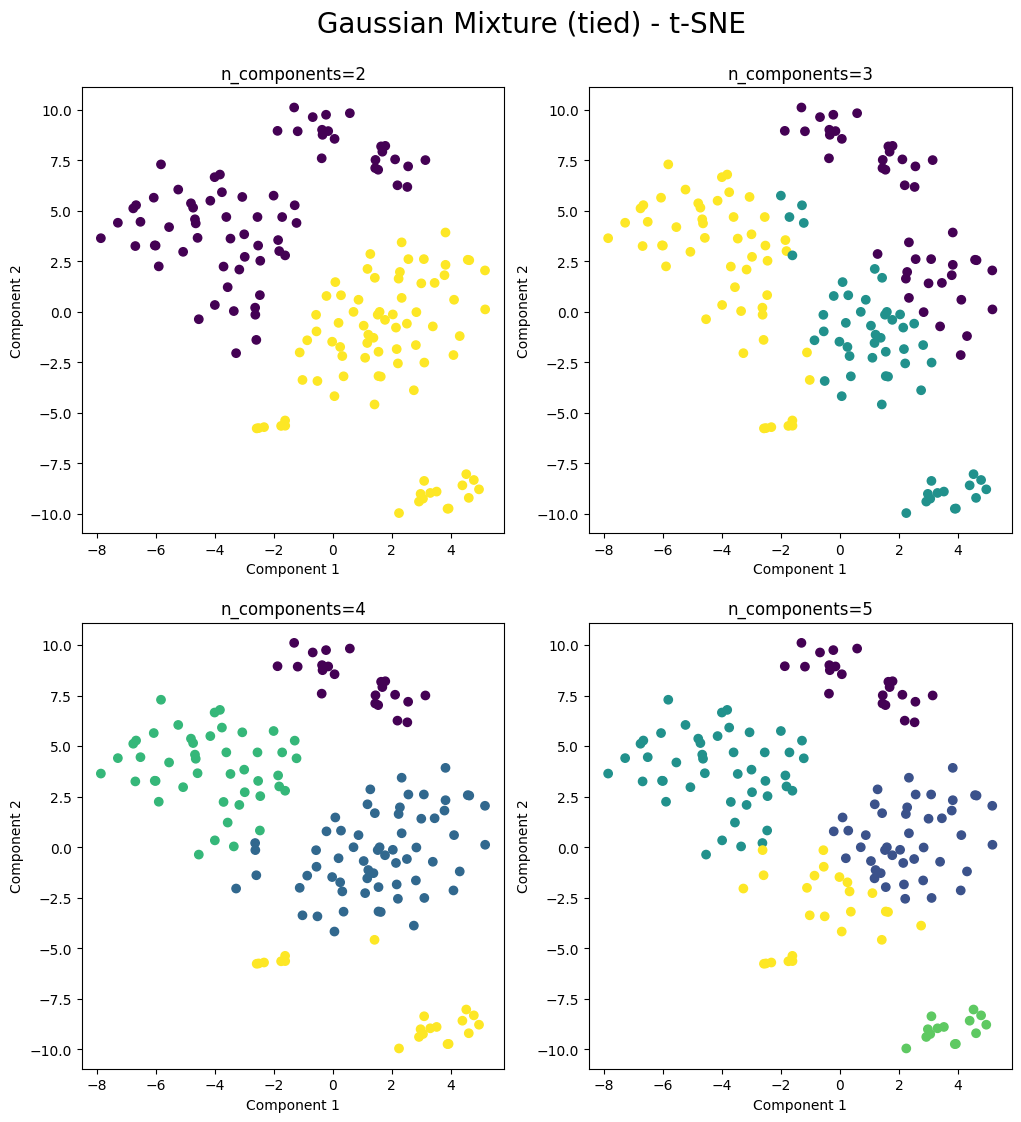

In [55]:
fig, axs = plt.subplots(2, 2, figsize=(12, 13), dpi=100)
plt.suptitle('Gaussian Mixture (tied) - t-SNE', fontsize=20, y=0.94)

tied_info = []

for n_components in range(2, 6):
    bic, silhouette = gaussian_mixture(X_tsne, n_components=n_components, covariance_type='tied', ax=axs[(n_components - 2)//2][n_components % 2])

    spherical_info.append({
        'n_components': n_components,
        'bic': bic,
        'silhouette': silhouette
    })

# Save figure
if not os.path.exists('../../figures/gaussian_mixture'):
    os.mkdir('../../figures/gaussian_mixture') 

plt.savefig(f'../../figures/gaussian_mixture/Gaussian Mixture - tSNE tied.png')

plt.show()

#### Diag

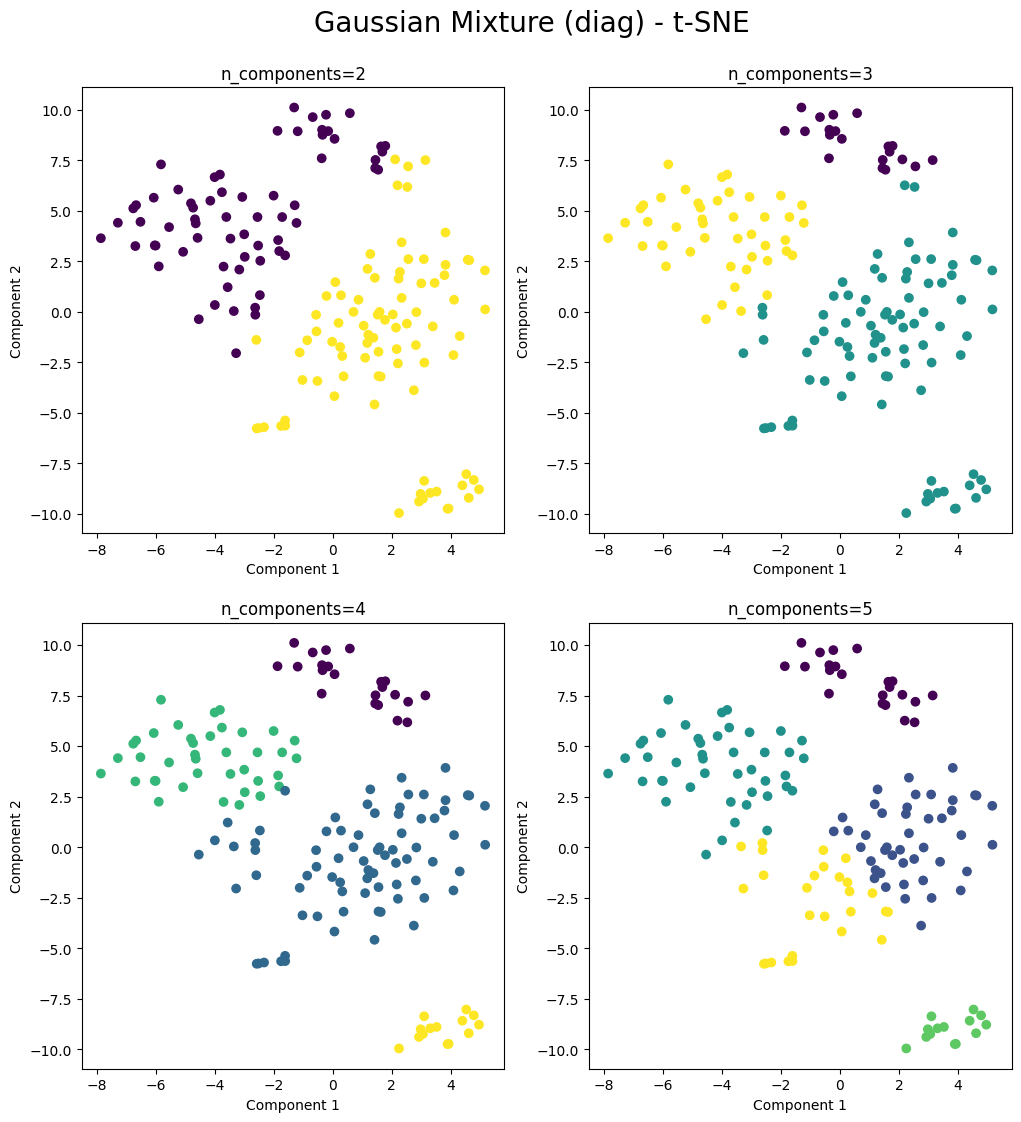

In [56]:
fig, axs = plt.subplots(2, 2, figsize=(12, 13), dpi=100)
plt.suptitle('Gaussian Mixture (diag) - t-SNE', fontsize=20, y=0.94)

diag_info = []

for n_components in range(2, 6):
    bic, silhouette = gaussian_mixture(X_tsne, n_components=n_components, covariance_type='diag', ax=axs[(n_components - 2)//2][n_components % 2])

    diag_info.append({
        'n_components': n_components,
        'bic': bic,
        'silhouette': silhouette
    })

# Save figure
if not os.path.exists('../../figures/gaussian_mixture'):
    os.mkdir('../../figures/gaussian_mixture') 

plt.savefig(f'../../figures/gaussian_mixture/Gaussian Mixture - tSNE diag.png')

plt.show()

#### Spherical

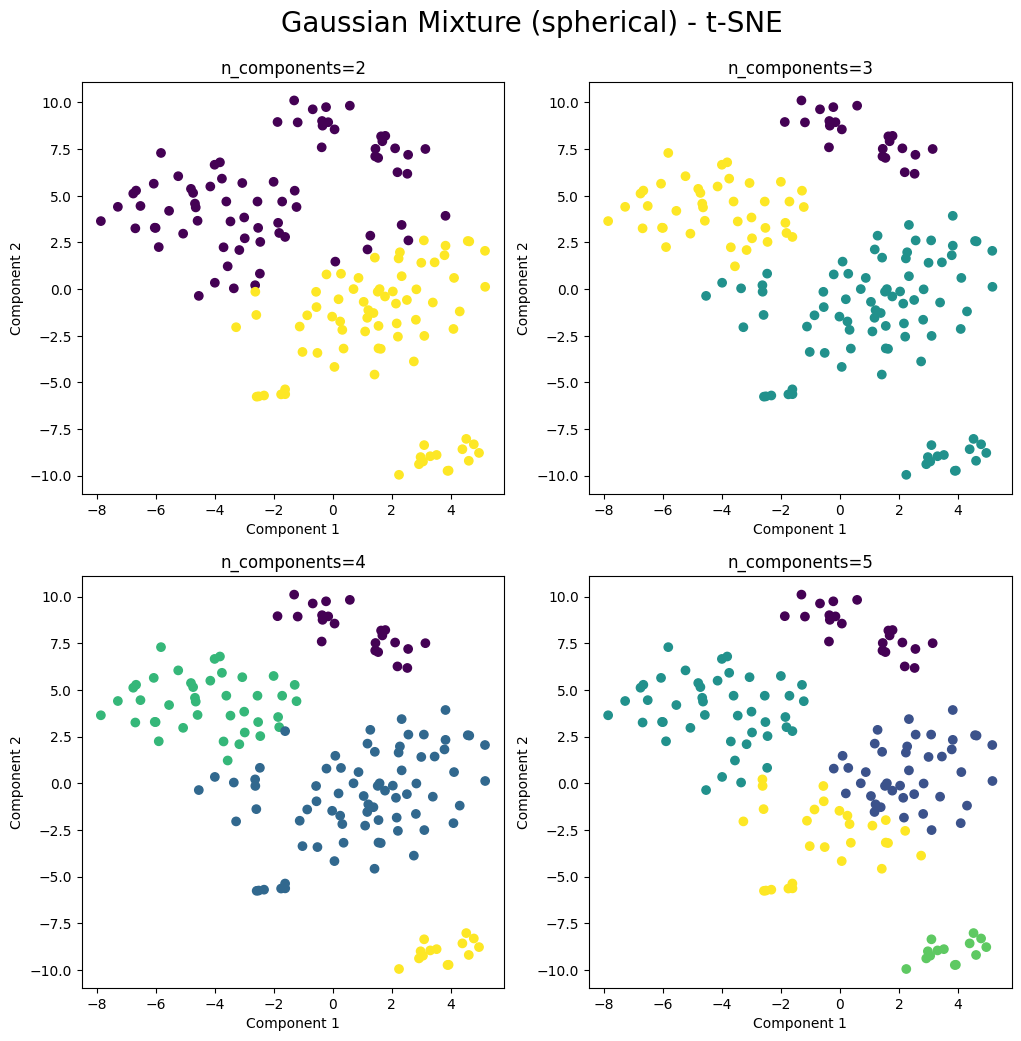

In [57]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12), dpi=100)
plt.suptitle('Gaussian Mixture (spherical) - t-SNE', fontsize=20, y=0.94)

spherical_info = []

for n_components in range(2, 6):
    bic, silhouette = gaussian_mixture(X_tsne, n_components=n_components, covariance_type='spherical', ax=axs[(n_components - 2)//2][n_components % 2])


    spherical_info.append({
        'n_components': n_components,
        'bic': bic,
        'silhouette': silhouette
    })

# Save figure
if not os.path.exists('../../figures/gaussian_mixture'):
    os.mkdir('../../figures/gaussian_mixture') 

plt.savefig(f'../../figures/gaussian_mixture/Gaussian Mixture - tSNE spherical.png')

plt.show()

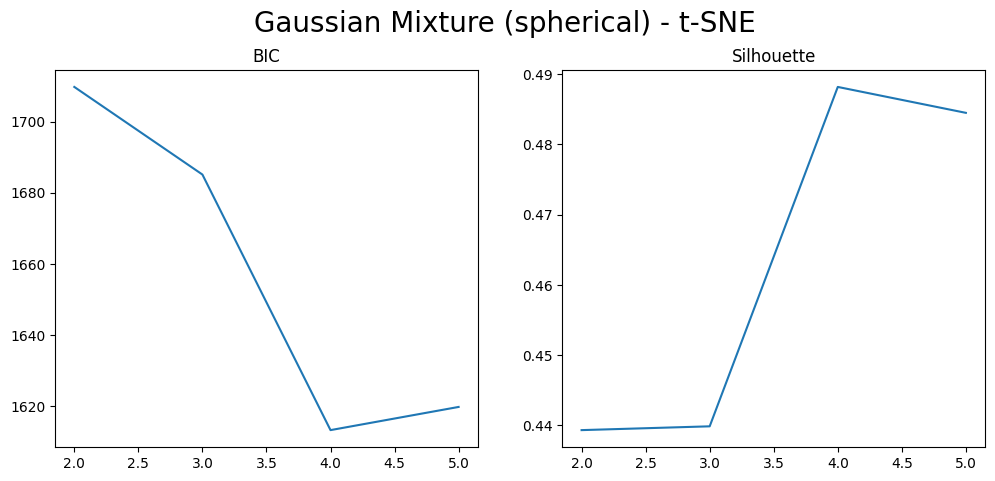

In [58]:
# plot bic and silhouette for spherical covariance type

fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=100)
plt.suptitle('Gaussian Mixture (spherical) - t-SNE', fontsize=20, y=1)

axs[0].plot([info['n_components'] for info in spherical_info], [info['bic'] for info in spherical_info])
axs[0].set_title('BIC')

axs[1].plot([info['n_components'] for info in spherical_info], [info['silhouette'] for info in spherical_info])
axs[1].set_title('Silhouette')

# Save figure
if not os.path.exists('../../figures/gaussian_mixture'):
    os.mkdir('../../figures/gaussian_mixture') 

plt.savefig(f'../../figures/gaussian_mixture/Gaussian Mixture - tSNE spherical bic_and_silhouette.png')

plt.show()